# In this notebook, we made model architecture using Keras` functional api
Naive architecture, not yet optimized

In [0]:
# Imports all the required modules function

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,Input,add
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import layers
from keras.models import Model

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [121]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


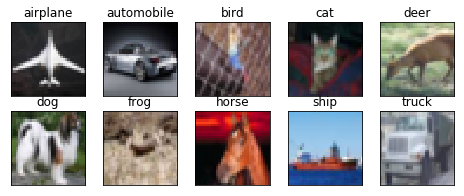

In [122]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#Function for plotting model history

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function for calculating validation test 

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#Using keras  functional api

In [0]:
from keras.callbacks import  ModelCheckpoint  # importing checkpoint

filepath="/content/gdrive/My Drive/EVA_session_6-3b.1_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"                                  # filepath in google drive to save weights
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)    # checkpoint to monitor validation accuracy, and save which give max accuracy

In [130]:
input = Input(shape=(32, 32, 3,))

#layer 1   Normal convolution
x = layers.Convolution2D(64, 3, 3, activation='relu',border_mode='same')(input) 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

#layer 2    Spatially Separable Convolution
x = layers.Convolution2D(128, 3, 1, activation='relu',border_mode='same')(x) 
layer_2 = layers.Convolution2D(128, 1, 3, activation='relu',border_mode='same')(x)
x = layers.BatchNormalization()(layer_2)
x = layers.Dropout(0.1)(x)

# layer 3 bottleneck
x = layers.MaxPooling2D(pool_size=(2, 2))(x)  
x = layers.Convolution2D(60, 1, 1, activation='relu')(x)
x= layers.BatchNormalization()(x)

#layer 4   Depthwise Separable Convolution
x = layers.SeparableConv2D(256, 3, 3, activation='relu',border_mode='same')(x) 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

# layer 5 bottleneck
x = layers.MaxPooling2D(pool_size=(2, 2))(x)  
x = layers.Convolution2D(30, 1, 1, activation='relu')(x)
x= layers.BatchNormalization()(x)

#layer 6 Group convolution
a = layers.Convolution2D(128, 3, 3, activation='relu',border_mode='same')(x) 
b = layers.Convolution2D(128, 5, 5, activation='relu',border_mode='same')(x)
x = layers.concatenate([a,b],axis=-1)

#layer 7 Group convolution with dilation
c = layers.Convolution2D(128, 3, 3, activation='relu',border_mode='same',dilation_rate=1)(x)
d = layers.Convolution2D(128, 3, 3, activation='relu',border_mode='same',dilation_rate=2)(x)
x = layers.concatenate([c,d],axis=-1)

output = layers.Convolution2D(num_classes, 8, 8, activation='relu')(x)
output = layers.Flatten()(output)
output = layers.Activation('softmax')(output)



model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 32, 32, 64)   1792        input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 32, 32, 64)   256         conv2d_186[0][0]                 
__________________________________________________________________________________________________
dropout_62 (Dropout)            (None, 32, 32, 64)   0           batch_normalization_96[0][0]     
__________________________________________________________________________________________________
conv2d_187

Epoch 1/50
390/390 [==============================] - 38s 97ms/step - loss: 2.1146 - acc: 0.2396 - val_loss: 2.1288 - val_acc: 0.2120

Epoch 00001: val_acc improved from -inf to 0.21200, saving model to /content/gdrive/My Drive/EVA_session_6-3b.1_weights-improvement-01-0.21.hdf5
Epoch 2/50
390/390 [==============================] - 31s 81ms/step - loss: 1.8388 - acc: 0.3311 - val_loss: 1.8305 - val_acc: 0.3195

Epoch 00002: val_acc improved from 0.21200 to 0.31950, saving model to /content/gdrive/My Drive/EVA_session_6-3b.1_weights-improvement-02-0.32.hdf5
Epoch 3/50
390/390 [==============================] - 31s 80ms/step - loss: 1.7360 - acc: 0.3502 - val_loss: 1.8195 - val_acc: 0.3425

Epoch 00003: val_acc improved from 0.31950 to 0.34250, saving model to /content/gdrive/My Drive/EVA_session_6-3b.1_weights-improvement-03-0.34.hdf5
Epoch 4/50
390/390 [==============================] - 31s 81ms/step - loss: 1.6773 - acc: 0.3595 - val_loss: 1.7501 - val_acc: 0.3412

Epoch 00004: val_ac

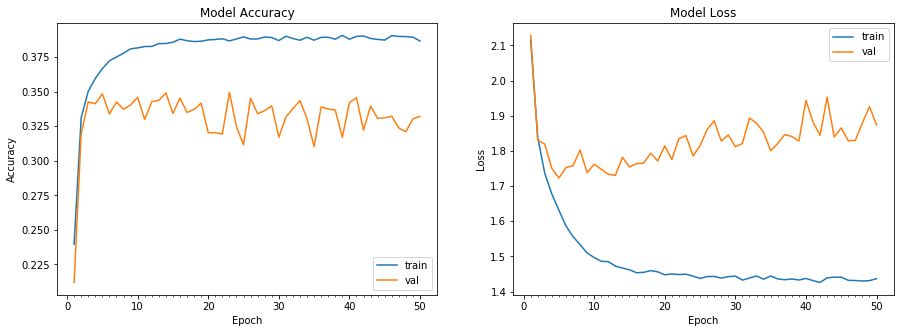

Accuracy on test data is: 33.21


In [131]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels),
                                 callbacks=[checkpoint],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))